L'objectif de notre projet est d'estimer le prix de location par nuit dans le service Airbnb sur Paris à partir d'un nombre défini de covariables.

Nous allons commencer d'abord par nettoyer le jeu de données.



In [ ]:
# Pour récupérer le jeu de données
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Premières Libraires utilisées :

In [ ]:
import os                                    # contient plusieurs fonctionnalités y parmis la manipulation des fichiers
import pandas as pd                          # module de manipulation des jeux de données (matrices)
import numpy as np                           # module de calculs mathématiques
from geopy.geocoders import Nominatim        # géocodage : coordinnées (longtitude, latitude) en l'adresse correspondante
import matplotlib.pyplot as plt              #figure

# Preprocessing 
Le jeu de données contient des les variables suivantes :


1.   clés d'identification (clés primaire/secondaire) sous le nom de 'id' et 'id_host'.
2.   le nombre de lits, de toilettes et des personnes pouvant se loger.
3.   le type du bien sous trois modalités : 'Appartement/Maison entière', 'Chambre partagée' et 'Chambre privée'.
4.   Le quartier et les coordonées.
5.   Le titre de l'annonce sur Airbnb.
5.   Le prix/nuit.

Nous importons le jeu de données :

In [ ]:
# Importation :
data_Paris = pd.read_csv(r'/content/drive/MyDrive/ProjetPython/listings_Paris.csv',on_bad_lines = 'skip', delimiter = ';') 

## une copie indépendante de la première source :
list_price_Paris = data_Paris.copy() 
list_price_Paris_obj = data_Paris.copy() 
list_price_Paris.head()


,id,host_id,room_type,neighbourhood,accommodates,bedrooms,bathrooms,beds,price,name,latitude,longitude
0,2577,2827,Entire home/apt,République,4,2.0,2.0,2.0,$125.00,Loft for 4 by Canal Saint Martin,48.869933,2.362511
1,3109,3631,Entire home/apt,Alésia,2,1.0,1.0,1.0,$75.00,zen and calm,48.833494,2.318518
2,5396,7903,Entire home/apt,Saint-Paul - Ile Saint-Louis,2,0.0,1.0,1.0,$115.00,Explore the heart of old Paris,48.851001,2.358690
3,7397,2626,Entire home/apt,Le Marais,4,2.0,1.0,2.0,$115.00,MARAIS - 2ROOMS APT - 2/4 PEOPLE,48.857576,2.352751
4,7964,22155,Entire home/apt,Gare du Nord - Gare de I'Est,2,2.0,1.0,2.0,$99.00,Large & sunny flat with balcony !,48.874642,2.343411


Il est primordial de traiter les valeurs manquantes avant d'entrainer les modèles avec ce jeu de données. Voici le nombre de NA par variable :

In [ ]:
nullseries = list_price_Paris.isnull().sum()
print(nullseries[nullseries > 0]) #les variables ou il n'y a aucune donnée manquante sont omis.

neighbourhood    2650
bedrooms           68
bathrooms          76
beds              228
name               74
dtype: int64


Nous vérifions également l'existence des doublons dans notre jeu de données (risque de sur-apprentissage plus petit) :

In [ ]:
# doublons:
print("nombre de doublons :", list_price_Paris.duplicated().sum())

nombre de doublons : 0


Nous allons au cours du script formater/recoder quelques variables, mais avant regardons leurs type :

In [ ]:
# le type des variables
list_price_Paris.dtypes

id                 int64
host_id            int64
room_type         object
neighbourhood     object
accommodates       int64
bedrooms         float64
bathrooms        float64
beds             float64
price             object
name              object
latitude         float64
longitude        float64
dtype: object

## Formattage de la variable 'price'

Nous remarquons que la variable des prix est une chaîne de charactères précédé par un '$'. Nous remarquons aussi que pour les valeurs qui dépassent 1000, le format ('1,000.00') contient une virgule qui ne permet pas la conversion en float.

In [ ]:
list_price_Paris['price'].dtypes  #type de la variable 'price' : string (Objet)

dtype('O')

In [ ]:
# les biens de prix 1000$ et leurs noms et id :
list_price_Paris[list_price_Paris['price']=='$1,000.00'][['id','price','name']].head()

,id,price,name
475,280475,"$1,000.00",**NEW**Super luxury w/Super view
1632,732458,"$1,000.00",Paris Montmartre Sacré Coeur House with big Ga...
2772,1206047,"$1,000.00",Charming apartment in Paris 20
5067,2488032,"$1,000.00",studio Metro nationale
13149,6755931,"$1,000.00",Joli studio au coeur de Paris 75009


En utilisant une compréhension de liste sur la liste des prix nous transformons les éléments de la colonne en une format convertible en float.


In [ ]:
# transformation des prix en format '...1234.45...' :
format_num = [float(price.replace(',','').split('$')[1]) for price in list_price_Paris['price']] 
print(format_num[0], ' type :',type(format_num[0]))

125.0  type : <class 'float'>


In [ ]:
# remplacement dans le dataset :
list_price_Paris['price'] = format_num # remplacement de la colonne
list_price_Paris.head() 

,id,host_id,room_type,neighbourhood,accommodates,bedrooms,bathrooms,beds,price,name,latitude,longitude
0,2577,2827,Entire home/apt,République,4,2.0,2.0,2.0,125.0,Loft for 4 by Canal Saint Martin,48.869933,2.362511
1,3109,3631,Entire home/apt,Alésia,2,1.0,1.0,1.0,75.0,zen and calm,48.833494,2.318518
2,5396,7903,Entire home/apt,Saint-Paul - Ile Saint-Louis,2,0.0,1.0,1.0,115.0,Explore the heart of old Paris,48.851001,2.358690
3,7397,2626,Entire home/apt,Le Marais,4,2.0,1.0,2.0,115.0,MARAIS - 2ROOMS APT - 2/4 PEOPLE,48.857576,2.352751
4,7964,22155,Entire home/apt,Gare du Nord - Gare de I'Est,2,2.0,1.0,2.0,99.0,Large & sunny flat with balcony !,48.874642,2.343411


La forme et le type des variables est désormais correcte, nous pouvons procéder à d'autres traitements.

## Gestion des outliers
Le jeu de données dispose de plusieurs valeurs abberantes dues a des erreurs d'enregistrement ou autre.
En particulier :

In [ ]:
list_price_Paris[(list_price_Paris['price'] == 25000) | (list_price_Paris['beds'] == 50)]        

,id,host_id,room_type,neighbourhood,accommodates,bedrooms,bathrooms,beds,price,name,latitude,longitude
39621,20433587,46443228,Private room,Saint-Germain-des-Prés - Odéon,16,50.0,50.0,50.0,85.0,Hotel rooms heart of Saint-Germain des Prés Odeon,48.854047,2.335844
39991,20691340,46443228,Private room,Saint-Germain-des-Prés - Odéon,16,50.0,50.0,50.0,85.0,Historic family hotel rooms Saint-Germain des ...,48.853066,2.335767
40077,20747725,46443228,Private room,Saint-Germain-des-Prés - Odéon,16,50.0,50.0,50.0,85.0,Charming Hotel the heart of Saint-Germain des ...,48.853353,2.337089
40098,20768013,46443228,Private room,Saint-Germain-des-Prés - Odéon,16,50.0,50.0,50.0,85.0,La Louisiane the heart of Saint-Germain des Prés,48.854049,2.336273
47117,24441436,184585722,Private room,Saint-Lazare,2,NaN,1.0,1.0,25000.0,Audacity & Chic in Paris 9th - Chambre Uno,48.881508,2.326565
47118,24441452,184585722,Private room,Saint-Lazare,2,1.0,1.0,1.0,25000.0,Audacity & Chic close to Montmartre,48.881951,2.326527
47120,24441474,184585722,Private room,Saint-Lazare,2,1.0,1.0,1.0,25000.0,Audacity & Chic close to the Sacré Cœur,48.881448,2.328070


L'IQR est l'Interquartile Range en anglais, qui est une mesure de la dispersion des données. Il est calculé en soustrayant le premier quartile (Q1) du troisième quartile (Q3),ce qui donne une idée de la "largeur" de la distribution des données autour de la médiane.  Il permet de définir une plage de valeurs "normales" pour les données.

Un outlier est toute valeur extrême, supérieure ou inférieure à I fois l’écart interquartile IQR. Généralement I vaut I= 1,5, dans notre cas on choisit I de telle sorte à ne pas trop reduire notre jeu de données.


In [ ]:
# Application sur les variables quantitatives :
for var in list_price_Paris.columns[4:9] :
  qn=np.quantile(list_price_Paris[var],[0.25,0.5,0.75,1])
  c = 15*(qn[2] - qn[0])
  list_price_Paris.drop(list_price_Paris[(list_price_Paris[var] == 0) | (list_price_Paris[var] > c )].index, axis=0, inplace=True)

La distribution des prix est plus homogène et s'accordent avec notre but d'estimer les prix/nuit standard d'un bien listé sur Airbnb : 

(47038, 12)

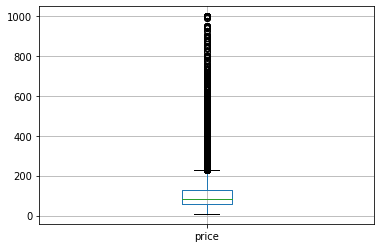

In [ ]:
list_price_Paris.boxplot('price')
list_price_Paris.shape

#Recodage et traitement des valeurs manquantes :

##Recodage de prix en classes :
Nous allons créer une variable 'class_price' qui aura 4 modalités (1 à 4) suivant les quantiles 0.25, 0.5, 0.75 et 1 de la variable 'price'

In [ ]:
# prix des biens et les éléments correspondants aux quantiles [25%, 50%, 75%, 100%] :
prices = list_price_Paris['price']
quantiles = np.quantile(prices,[0.25,0.5,0.75,1])

# classification des prix :
class_price = [4 if (price > quantiles[2] and price > 3) else price for price in [
                3 if (price <= quantiles[2] and price > 2) else price for price in [
                  2 if (price <= quantiles[1] and price > 1) else price for price in [
                    1 if (price <= quantiles[0] and price > 0) else price for price in prices]]]]  #la compréhension est fausse sans gestion d'outliers (si un prix <=3) -> les prix = 0 resteront 0 en 'class_price'
list_price_Paris['class_price'] = class_price

# vérification : 
list_price_Paris[list_price_Paris['class_price']>4] 

,id,host_id,room_type,neighbourhood,accommodates,bedrooms,bathrooms,beds,price,name,latitude,longitude,class_price


##Traitement des valeurs manquantes de la variable neighborhood :

L'idée est d'utiliser les coordonnées avec un géocodeur pour obtenir les quartiers/arrondissement des biens listés.

In [ ]:
#l'éxecution prend un moment >10 min

na_nd_coords = list_price_Paris[list_price_Paris['neighbourhood'].isnull()][['latitude','longitude']]
geolocator = Nominatim(user_agent="geoapiExercises")
adresses = []
for i in na_nd_coords.index:
  coords = (na_nd_coords['latitude'].loc[i],na_nd_coords['longitude'].loc[i])
  location = geolocator.reverse(coords, timeout=10)
  if 'suburb' in location.raw['address'].keys() :
    word = 'suburb'
  else :
    word = 'county'
  list_price_Paris.iloc[i,3] = location.raw['address'][word]
  adresses.append(location.raw['address'][word])



In [ ]:
adresses[1:10]  # Les premiers 10 adresses précédemment NA

['Quartier de Clignancourt',
 'Paris 19e Arrondissement',
 'Paris 13e Arrondissement',
 'Paris 19e Arrondissement',
 'Paris 11e Arrondissement',
 'Paris 3e Arrondissement',
 'Paris 11e Arrondissement',
 'Quartier de Grenelle',
 'Quartier de Clignancourt']

##Traitement des valeurs manquantes des variables 'beds', 'bedrooms' et 'bathrooms' :
Nous implémenter une imputation par moyenne des échantillons correspondants aux modalités des variables room_type et class_price.

In [ ]:
# jeux de données des classes de prix par modalités des variables (en ordre) room_type et class_price : 
l_beds = [list_price_Paris[list_price_Paris['room_type'] == r_t][['beds', 'class_price']] for r_t in ['Entire home/apt', 'Private room', 'Shared room']]
l_bedrooms = [list_price_Paris[list_price_Paris['room_type'] == r_t][['bedrooms', 'class_price']] for r_t in ['Entire home/apt', 'Private room', 'Shared room']]
l_bathrooms = [list_price_Paris[list_price_Paris['room_type'] == r_t][['bathrooms', 'class_price']] for r_t in ['Entire home/apt', 'Private room', 'Shared room']]

moy_beds, moy_bedrooms, moy_bathrooms = [0,0,0,0], [0,0,0,0], [0,0,0,0]
for cl in [1,2,3,4] :
  moy_beds[cl-1] = [ls[ls['class_price'] == cl]['beds'].mean() for ls in l_beds]
  moy_bedrooms[cl-1] = [ls[ls['class_price'] == cl]['bedrooms'].mean() for ls in l_bedrooms]
  moy_bathrooms[cl-1] = [ls[ls['class_price'] == cl]['bathrooms'].mean() for ls in l_bathrooms]

# moyenne du nombre de lits pour les 3 modalités (resp. 4) de la variable room_type (resp. class_price) 
moys = {'beds': moy_beds, 'bedrooms' : moy_bedrooms, 'bathrooms' : moy_bathrooms} 
moy_beds

[[1.3643948145295854, 1.106604609929078, 2.287531806615776],
 [1.5537559618441972, 1.4634615384615384, 1.2647058823529411],
 [1.8599664366958792, 1.371641791044776, 1.2666666666666666],
 [2.69445716903344, 1.771604938271605, 2.1]]

In [ ]:
# remplacement dans le jeu de données 
for var in ['beds', 'bathrooms', 'bedrooms'] :
  s = 0
  for rt in ['Entire home/apt', 'Private room', 'Shared room'] :
    for cl in [1,2,3,4] :
      ind = list_price_Paris.loc[(list_price_Paris[var].isnull()) & (list_price_Paris['room_type'] == rt) & (list_price_Paris['class_price'] == cl), var].index
      for i in ind :
        list_price_Paris.loc[(list_price_Paris[var].isnull()) & (list_price_Paris['room_type'] == rt) & (list_price_Paris['class_price'] == cl), var] = moys[var][cl-1][s]
    s = s + 1


In [ ]:
#vérification
#list_price_Paris.to_csv('/content/drive/MyDrive/ProjetPython/2eformatage.csv') 
nullseries = list_price_Paris.isnull().sum()
print(nullseries[nullseries > 0]) 

neighbourhood    2069
name               52
dtype: int64


#Modélisation :

Les variables utilisées dans la modélisation sont : 

1.   class_price comme variable target
2.   accommodates
3.   bedrooms, beds, bathrooms
4.   room_type dummifié



##Dummification de la variable room_type

In [ ]:
mod_data = list_price_Paris.iloc[:,[12,2,3,4,5,6,7]].dropna() #jeu de données de modélisation
nullseries = mod_data.isnull().sum()
print(nullseries[nullseries > 0]) #aucune donnée manquante

Series([], dtype: int64)


In [ ]:
mod_data.head()

,class_price,room_type,accommodates,bedrooms,bathrooms,beds
0,3,Entire home/apt,4,2.0,2.0,2.0
1,2,Entire home/apt,2,1.0,1.0,1.0
3,3,Entire home/apt,4,2.0,1.0,2.0
4,3,Entire home/apt,2,2.0,1.0,2.0
5,3,Entire home/apt,3,1.0,1.0,1.0


Nous allons ensuite dummifier la variable room_type :

In [ ]:
data_mod = pd.get_dummies(mod_data, columns=['room_type' , 'neighbourhood'])
data_mod.head()

,class_price,accommodates,bedrooms,bathrooms,beds,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_Alésia,neighbourhood_Austerlitz,...,neighbourhood_XI Arrondissement,neighbourhood_XII Arrondissement,neighbourhood_XIII Arrondissement,neighbourhood_XIV Arrondissement,neighbourhood_XIX Arrondissement,neighbourhood_XV Arrondissement,neighbourhood_XVI Arrondissement,neighbourhood_XVII Arrondissement,neighbourhood_XVIII Arrondissement,neighbourhood_XX Arrondissement
0,3,4,2.0,2.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,1.0,1.0,1.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,2.0,1.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2,2.0,1.0,2.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,3,1.0,1.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


échantillonage des jeux de données d'entrainement et de test :

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_mod.loc[:, data_mod.columns != "class_price"], data_mod.class_price, test_size = 0.3)
X_train.head()

,accommodates,bedrooms,bathrooms,beds,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_Alésia,neighbourhood_Austerlitz,neighbourhood_Auteuil,...,neighbourhood_XI Arrondissement,neighbourhood_XII Arrondissement,neighbourhood_XIII Arrondissement,neighbourhood_XIV Arrondissement,neighbourhood_XIX Arrondissement,neighbourhood_XV Arrondissement,neighbourhood_XVI Arrondissement,neighbourhood_XVII Arrondissement,neighbourhood_XVIII Arrondissement,neighbourhood_XX Arrondissement
15445,4,1.0,1.0,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9266,4,1.0,1.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36609,5,4.0,3.0,5.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43782,4,2.0,1.0,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49514,2,1.0,1.0,1.0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Définition et entraînement des modéles :
Nous utilisons une régression logistique, les forêts aléatoires, le gradient boosting et l'XGB (x pour extreme).
Les modèles sont définis séparemment et entrainés dans une compréhension de liste.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost.sklearn import XGBClassifier 

mod_LR = LogisticRegression()
mod_RF = RandomForestClassifier()
mod_GBT = GradientBoostingClassifier()
mod_XGB = XGBClassifier()

list_mods = [mod_LR, mod_RF, mod_GBT, mod_XGB]
mods_fit = [mod.fit(X_train, y_train) for mod in list_mods] #liste des modèles entrainés


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Avec ces modèles on dispose d'une précision de classification de ~52% :

In [ ]:
for mod in mods_fit :
  print(mod, "score : ", mod.score(X_test, y_test)) 

LogisticRegression() score :  0.5264250240901341
RandomForestClassifier() score :  0.5211622563190275
GradientBoostingClassifier() score :  0.5270921354977393
XGBClassifier(objective='multi:softprob') score :  0.5227929730931732


Nous allons donc essayer de trouver les meilleurs paramètres a utiliser en entraînant les paramètres sur une multitude de valeurs et choisir celui qui maximise la précision de la classification.

## Optimisation des paramètres :

En utilisant la fonction GridSearchCV, on défini plusieurs modéles suivant des combinaisons de valeurs pour les paramètres de chaque modèle.

In [ ]:
from sklearn.model_selection import GridSearchCV

seed = 20 

# Paramètres des modèles utilisées :
param_LR = {
            'penalty'     : ['l1', 'l2'],
            'tol'         : [1e-4, 5e-4, 1e-3, 1e-2],
            'C'           : [10.0, 5.0, 2.0],
            'class_weight': ['balanced', None],
            'random_state': [seed]
           }

param_RF = {
            'n_estimators' : [20, 50,100],
            'max_depth' : [4,5,7,8,9,10], 
            'random_state' : [seed],
            'class_weight':[None, 'balanced']
           }

param_GB = {
            'n_estimators' : list(range(1,10)),
            'max_depth'    : list(range(1,10)), 
            'random_state' : [seed],
            'max_features' : ['auto', 'sqrt','log2']
           }

param_XGB = {
              'n_estimators' : [20, 50,100],
              'max_depth' : [4,5,7,8,9,10],
              'learning_rate' : [1e-1, 1e-2, 1e-3, 1e-4],
              'seed' : [seed]
            }

mod_LR = GridSearchCV(estimator=LogisticRegression(),param_grid=param_LR)
mod_RF = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_RF)
mod_GB = GridSearchCV(estimator=GradientBoostingClassifier(),param_grid=param_GB)
mod_XGB = GridSearchCV(estimator=XGBClassifier(),param_grid=param_XGB)


mods_opti = [mod.fit(X_train, y_train) for mod in [mod_LR, mod_RF, mod_GB, mod_XGB]]


NameError: ignored

Nous obtenons ainsi les meilleurs paramètres pour chacun de nos modèles

In [ ]:
for mod in mods_opti :
  print("Meilleurs paramètres de :", mod, " ",mod.best_params_)

In [ ]:
for mod in mods_opti :
  print("Score du modèle :", mod, " ",mod.score(X_test, y_test))

0.4765399154992217

#NLP sur la variable 'name' :
Le traitement de la variable name peut se réveler utile pour nos modèles, en effet un titre bien soigné peut permettre à l'annonceur de louer son bien à des prix plus élevé et garantir une croissance de la clientèle.

In [ ]:
import nltk
#important a installer :

nltk.download('omw-1.4')
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Nous allons implémenter dans un premier temps une fonction qui coupe un texte en mots ou en phrases. la fonction enlève dans le cas d'un découpage par mots les virgules et autres syntaxes. Elle permet aussi de renvoyer les mots uniques dans le texte.

In [ ]:
# Méthodes :
## Split/tokenization : 

def split(text, by = "mot", unique_valeurs = False) : # par mots ou phrases (sentence)
  if by == "phrase" :
    sortie = nltk.sent_tokenize(text)
  else :
    sortie = nltk.word_tokenize(text)
    stopwords =[",", ".", "!", "?", "-", "/", "_", ":", '"', "'", "*"]
    for sw in stopwords :
      sortie = [ele for ele in sortie if ele != sw]
  if unique_valeurs == True:
    sorite = list(set(sortie))
  return sortie


In [ ]:
split("Un texte est une série orale ou écrite de mots perçus comme constituant un ensemble cohérent, porteur de sens et utilisant les structures propres à une langue (conjugaisons, construction et association des phrases…). Un texte n'a pas de longueur déterminée sauf dans le cas de poèmes à forme fixe comme le sonnet ou le haïku.")

On implémente ensuite des fonctions qui permettent de relever la racine et le type grammatical d'un mot :

In [ ]:
## Identification grammatical (nom, adverbe, adjectif,...):

def identif_gra(text) :
  return nltk.pos_tag(split(text))
  
## Racines des mots :

def racines_mot(text, unique = 0) : # la fonction a pour but de donner les racines des mots (sunny -> sun) ##ne marche pas
  lemmatizer = nltk.stem.WordNetLemmatizer()
  if unique == 1 :
    L = list(set(split(text)))
  else :
    L = split(text)
  return [lemmatizer.lemmatize(ele) for ele in L]  

In [ ]:
identif_gra("école")

[('école', 'NN')]

Finalement une fonction qui résume en statistiques les méthodes précédentes 

In [ ]:
def stats_nlp(text, include_sentence = False) :
  mots = list(set(split(text)))
  vide = [0 for x in range(len(mots))]
  stats = pd.DataFrame({'Mot' : mots, 'Nb' : vide }) # mots sans répétition
  i = 0
  while i < len(mots) :#occurence de chaque mot
    stats.iloc[i,1] = split(text).count(stats.iloc[i,0])
    i = i + 1 
  return stats

In [ ]:
text = "It's a large and sunny place, the view is amazing."
stats_nlp(text) 

NameError: ignored

#Conclusion :
Nous avons pu appliquer le long de ce projet plusieurs méthodes de traitement de données et nous avons modéliser la classe du prix/nuit d'un bien listé sur Airbnb avec une première précision de 52%.
Nous avons remarqué que la précision augmente avec le nombre de données qu'on dispose. D'autres pistes d'améliorations sont disponibles :


1.   Recoder entièrement la variable 'neighbourhood' en Arrondissements ce qui résultera en une meilleure dummification.
2.   Créer des variables supplémentaire en développant la partie NLP (ex : classification du texte le plus soigné).
3.   Utiliser les données d'autres villes.

